In [1]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [42]:
_set_env("GOOGLE_API_KEY")

In [ ]:
# os.getenv("GOOGLE_API_KEY")

In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "pr-aching-coincidence-98"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [3]:
from langchain_ollama import OllamaLLM, ChatOllama
from langchain_community.document_loaders import PyPDFLoader
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.schema import Document
from langgraph.graph import END
import operator
from typing_extensions import TypedDict
from typing import List, Annotated
import json
import requests
from pprint import pprint
from langsmith import traceable
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings


c:\Users\mario\.conda\envs\lancedb\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# llm
local_llm = "llama3.1"
base_url = "http://localhost:11434"
llm = OllamaLLM(model=local_llm, base_url=base_url, temperature=0, model_kwargs={'device': 'gpu'})
llm_json_mode = OllamaLLM(model=local_llm, temperature=0, format="json", model_kwargs={'device': 'gpu'})

In [ ]:
# llm
local_llm = "gemini-1.5-flash-8b"
llm = ChatGoogleGenerativeAI(model=local_llm)
llm_json_mode = ChatGoogleGenerativeAI(model=local_llm)

In [ ]:
gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [5]:
persist_location = "C:/Users/mario/rag_notebooks/sklearn_vector_store_backup"

In [ ]:
# load documents
pdf_file = "C:/Users/mario/Downloads/Expert_Python_Programming.pdf"
pdf_file2 = "C:/Users/mario/Downloads/Python.Algorithms.pdf"
pdf_file3 = "C:/Users/mario/Downloads/deep-learning-with-tensorflow-20-and-keras.pdf"
loader = PyPDFLoader(pdf_file3)
doc = loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500,
    chunk_overlap=20
)
docs_split = text_splitter.split_documents(doc)

In [106]:
# add vector db
vectorstore = SKLearnVectorStore.from_documents(
    documents=docs_split,
    embedding=OllamaEmbeddings(model="nomic-embed-text"),
    persist_path=persist_location + "/vectorstore.parquet",
    serializer="parquet"
)

NameError: name 'docs_split' is not defined

In [ ]:
# add vector db
vectorstore = SKLearnVectorStore.from_documents(
    documents=docs_split,
    embedding=gemini_embeddings,
    persist_path=persist_location + "/geminivectorstore.parquet",
    serializer="parquet"
)

In [ ]:
loaded_vector_store.add_documents(docs_split)

In [ ]:
# persist vectorstore
loaded_vector_store.persist()

In [ ]:
# Load the vector store from disk
loaded_vector_store = SKLearnVectorStore(
    embedding=gemini_embeddings,
    persist_path=persist_location + "/geminivectorstore.parquet",
    serializer="parquet"
)

In [6]:
# Load the vector store from disk
loaded_vector_store = SKLearnVectorStore(
    embedding=OllamaEmbeddings(model="nomic-embed-text"),
    persist_path=persist_location + "/vectorstore.parquet",
    serializer="parquet"
)

In [7]:
retriever = loaded_vector_store.as_retriever(k=3)

In [ ]:
# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Return an answer that is informative, concise, and relevant using lists and code blocks when appropriate.

The answer should be no longer than 5 sentences.

Answer:"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Test
question = "Can you tell me how the weather is today in Irving TX?"

# web_search = True
web_search = False

# search_url = "http://localhost:8080/search"
# res = requests.get(search_url, params={"q": question, "format": "json"})
# web_results = res.json()['results'][:5]

# docs = [Document(page_content=d['content'], metadata={'source': d['url'], 'page': "Web page"}) for d in web_results]
# print(docs)
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)

# generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
for chunk in llm.stream([HumanMessage(content=rag_prompt_formatted)]):
    print(chunk.content, end="")
    if chunk.content == ".":
        print('\n')

print("\nSources: ")
for i in docs:
    if web_search:
        source = i.metadata['source']
        page = i.metadata['page']
    else:
        source = i.to_json()['kwargs']['metadata']['source'].split("/")[-1]
        page = i.to_json()['kwargs']['metadata']['page']
    print(f'{source} page: {page}')

In [ ]:
question = "github deeplearning repos"

In [ ]:
search_url = "http://localhost:8080/search"
res = requests.get(search_url, params={"q": question, "format": "json"})
res.json()['results'][:5]

In [ ]:
res.json()['results'][0]['content']

In [ ]:
for i in res.json()['results']:
    print(i['title'])
    print(i['url'])
    pprint(i['content'])
    print(i['score'])
    print('\n')

## Components

In [66]:
### Router

# Prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related to tensorflow, keras, deep learning and python.

Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.

Return a JSON with the single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""

# Test router
test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [
        HumanMessage(
            content="Who is favored to win the NFC Championship game in the 2024 season?"
        )
    ]
)
test_web_search_2 = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the models released today for llama3.2?")]
)
test_vector_store = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="How can I create a regression model using keras in tensorflow?")]
)
print((json.loads(test_web_search)['datasource']),
    # json.loads(test_web_search.content),
    # json.loads(test_web_search_2.content),
    # json.loads(test_vector_store.content),
)

# print(
#     json.loads(test_web_search.content.split("```json")[1].split("```")[0]),
#     (test_web_search_2.content),
#     (test_vector_store.content),
# )


websearch


In [ ]:
test_web_search

In [ ]:
### Retrieval Grader

# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# Test
question = "How can I create a regression model using keras in tensorflow?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
json.loads(result.content)

In [ ]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 

Here is the context to use to answer the question:

{context} 

Think carefully about the above context. 

Now, review the user question:

{question}

Provide an answer to this questions using only the above context. 

Use three sentences maximum and keep the answer concise.

Answer:"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Test
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
pprint(generation.content)

In [ ]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """

You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

# Test using documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt, generation=generation.content
)
result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)
json.loads(result.content)

In [ ]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 

Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

# Test
question = "What are the vision models released today as part of Llama 3.2?"
answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct, which are available on Azure AI Model Catalog via managed compute. These models are part of Meta's first foray into multimodal AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the older text-only Llama 3.1 models."

# Test using question and generation from above
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question, generation=answer
)
result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)
json.loads(result.content)

In [8]:
class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

In [9]:
### Nodes
@traceable
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}

In [10]:
@traceable
def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    # Prompt
    rag_prompt = """You are an assistant for question-answering tasks. 

    Here is the context to use to answer the question:

    {context} 

    Think carefully about the above context. 

    Now, review the user question:

    {question}

    Provide an answer to this questions using only the above context. 

    Format the answer to be informative, concise, and relevant using lists and code blocks when appropriate.

    The answer should be no longer than 500 words.
    
    Answer:"""

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}

In [11]:
@traceable
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    # Doc grader instructions
    doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

    # Grader prompt
    doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

    This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

    Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result)["binary_score"]
        
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}

In [12]:
@traceable
def web_search_tool(question):
    search_url = "http://localhost:8080/search"
    res = requests.get(search_url, params={"q": question, "format": "json"})
    web_results = res.json()['results'][:5]

    docs = [Document(page_content=d['content'], metadata={'source': d['url'], 'page': "Web page"}) for d in web_results]

    return docs

In [13]:
@traceable
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool(question)
    documents.extend(docs)
    return {"documents": documents}

In [14]:
### Edges

@traceable
def route_question(state):
    """
    Route question to web search or RAG

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    # Prompt
    router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

    The vectorstore contains documents related to tensorflow, keras, deep learning and python.

    Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.

    Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    if local_llm == "gemini-1.5-flash-8b":
        source = json.loads(route_question.content.split("```json")[1].split("```")[0])["datasource"]
    else:
        source = json.loads(route_question)["datasource"]
        
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [15]:
@traceable
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [16]:
@traceable
def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    # Hallucination grader instructions
    hallucination_grader_instructions = """

    You are a teacher grading a quiz. 

    You will be given FACTS and a STUDENT ANSWER. 

    Here is the grade criteria to follow:

    (1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

    (2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

    Score:

    A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

    A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

    Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

    Avoid simply stating the correct answer at the outset."""

    # Grader prompt
    hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

    Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

    # Answer grader instructions
    answer_grader_instructions = """You are a teacher grading a quiz. 

    You will be given a QUESTION and a STUDENT ANSWER. 

    Here is the grade criteria to follow:

    (1) The STUDENT ANSWER helps to answer the QUESTION

    Score:

    A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

    The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

    A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

    Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

    Avoid simply stating the correct answer at the outset."""

    # Grader prompt
    answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 

    Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    if local_llm == "gemini-1.5-flash-8b":
        grade = json.loads(result.content.split("```json")[1].split("```")[0])["binary_score"]
    else:
        grade = json.loads(result)["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )

        if local_llm == "gemini-1.5-flash-8b":
            grade = json.loads(result.content.split("```json")[1].split("```")[0])["binary_score"]
        else:
            grade = json.loads(result)["binary_score"]

        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

In [17]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

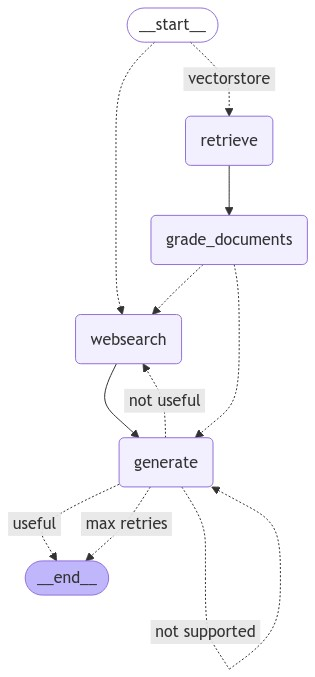

In [18]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# Test on current events
inputs = {
    "question": "How can I create a streamlit app to display my local LLM?",
    "max_retries": 3,
}

for event in graph.stream(inputs, stream_mode="values"):
        pprint(event)
        print(event.keys())
        if event.get("generation"):
            pprint(event.get("generation", {}))


---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'loop_step': 0,
 'max_retries': 3,
 'question': 'How can I create a streamlit app to display my local LLM?'}
dict_keys(['question', 'max_retries', 'loop_step'])
---WEB SEARCH---
{'documents': [Document(metadata={'source': 'https://docs.streamlit.io/develop/tutorials/llms/build-conversational-apps', 'page': 'Web page'}, page_content="st.chat_input lets you display a chat input widget so the user can type in a message. The returned value is the user's input, which is None if the user hasn't sent a message yet. You can also pass in a default prompt to display in the input widget. Here's an example of how to use st.chat_input to display a chat input widget and show the user's input:"),
               Document(metadata={'source': 'https://docs.streamlit.io/develop/tutorials/llms/llm-quickstart', 'page': 'Web page'}, page_content="OpenAI, LangChain, and Streamlit in 18 lines of code. In this tutorial, you will build a Streamlit LLM app